In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

pd.set_option("display.max_columns", None)

# Carregando base de dados

In [3]:
formated_df = pd.read_csv("bases_de_dados/base_de_dados_formatada_rim.csv")
n_amostras = 105620
formated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47598 entries, 0 to 47597
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   uf                 47598 non-null  object 
 1   regiao             47598 non-null  object 
 2   data_da_inscricao  47598 non-null  object 
 3   sexo               47598 non-null  object 
 4   grupo_sanguineo    47598 non-null  object 
 5   cor                47598 non-null  object 
 6   uf_origem          47598 non-null  object 
 7   tipo_de_doador     38331 non-null  object 
 8   idade              47598 non-null  float64
 9   data_do_evento     47598 non-null  object 
 10  obito_bin          47598 non-null  int64  
 11  transplante_bin    47598 non-null  int64  
 12  delta_t            47598 non-null  float64
dtypes: float64(2), int64(2), object(9)
memory usage: 4.7+ MB


# Kaplan-meier

obito: 
amostras negativas:  10
amostras positivas:  9257
transplante: 
amostras negativas:  231
amostras positivas:  38100
Fila: 
amostras negativas:  241
amostras positivas:  47357


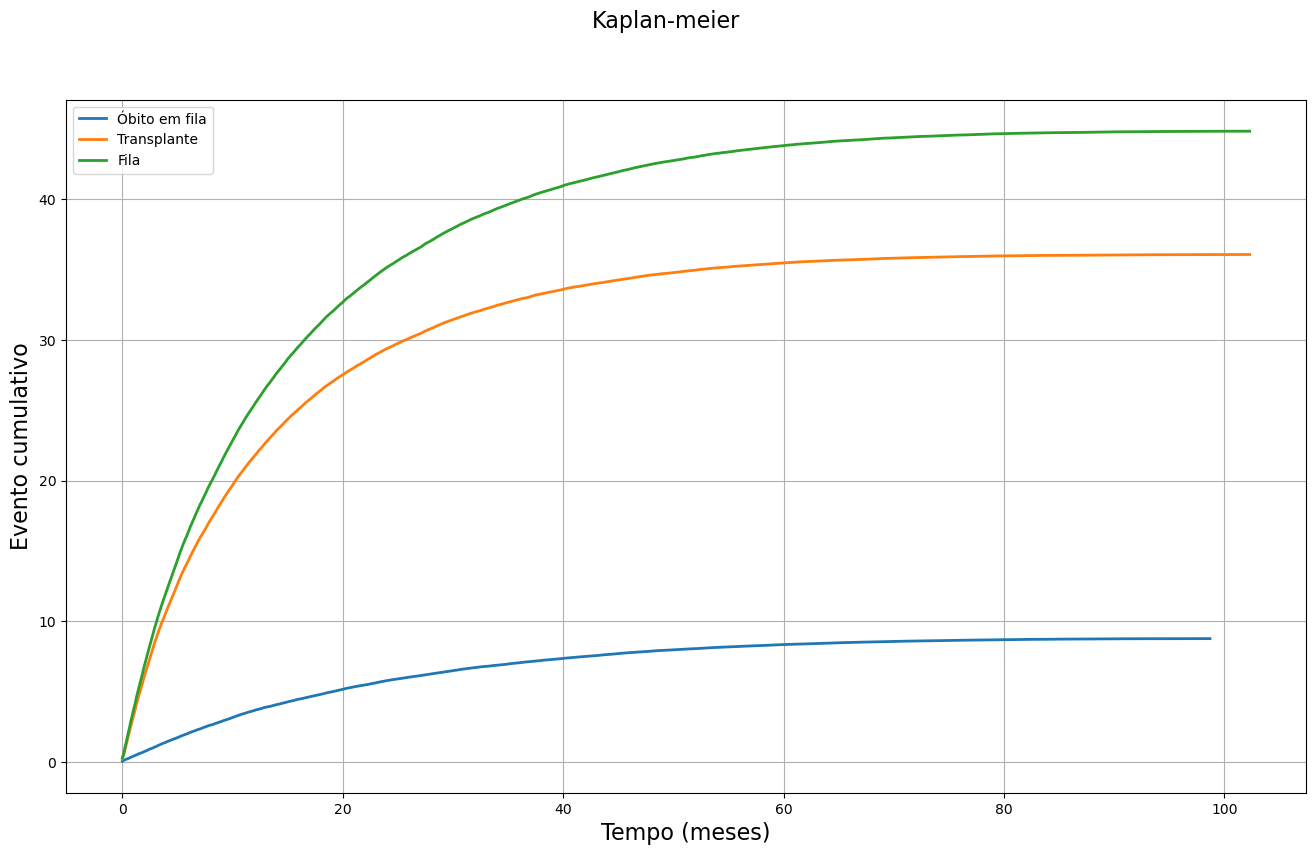

<Figure size 640x480 with 0 Axes>

In [4]:
scale = 1
width = 16
height = 9

fig = plt.figure(figsize=[scale * width, scale * height])
ax = fig.add_subplot(1, 1, 1)
fig.suptitle("Kaplan-meier", fontsize=16)

# Plotando curva de óbito
print("obito: ")
seg_delta_t_negativo = formated_df.delta_t.loc[
    (formated_df.delta_t < 0) & (formated_df.obito_bin == 1)
]
seg_delta_t_positivo = formated_df.delta_t.loc[
    (formated_df.delta_t >= 0) & (formated_df.obito_bin == 1)
]

unique_delta, count = np.unique(seg_delta_t_positivo, return_counts=True)

percentage = []
acumulada = 0

for n_vezes in count:
    acumulada += (n_vezes / n_amostras) * 100
    percentage.append(acumulada)

# Plotando 2D

ax.plot(unique_delta / 30, percentage, linewidth=2, label="Óbito em fila")

print("amostras negativas: ", len(seg_delta_t_negativo))
print("amostras positivas: ", len(seg_delta_t_positivo))

# Plotando a curva do transplante
print("transplante: ")
seg_delta_t_negativo = formated_df.delta_t.loc[
    (formated_df.delta_t < 0) & (formated_df.transplante_bin == 1)
]
seg_delta_t_positivo = formated_df.delta_t.loc[
    (formated_df.delta_t >= 0) & (formated_df.transplante_bin == 1)
]

unique_delta, count = np.unique(seg_delta_t_positivo, return_counts=True)

percentage = []
acumulada = 0

for n_vezes in count:
    acumulada += (n_vezes / n_amostras) * 100
    percentage.append(acumulada)

# Plotando 2D

ax.plot(unique_delta / 30, percentage, linewidth=2, label="Transplante")

print("amostras negativas: ", len(seg_delta_t_negativo))
print("amostras positivas: ", len(seg_delta_t_positivo))

print("Fila: ")
seg_delta_t_negativo = formated_df.delta_t.loc[(formated_df.delta_t < 0)]
seg_delta_t_positivo = formated_df.delta_t.loc[(formated_df.delta_t >= 0)]

unique_delta, count = np.unique(seg_delta_t_positivo, return_counts=True)

percentage = []
acumulada = 0

for n_vezes in count:
    acumulada += (n_vezes / n_amostras) * 100
    percentage.append(acumulada)

# Plotando 2D

ax.plot(unique_delta / 30, percentage, linewidth=2, label="Fila")

print("amostras negativas: ", len(seg_delta_t_negativo))
print("amostras positivas: ", len(seg_delta_t_positivo))

ax.set_ylabel("Evento cumulativo", fontsize=16)
ax.set_xlabel("Tempo (meses)", fontsize=16)

ax.legend()
ax.grid()

plt.show()

plt.savefig("figures/kpm.png")

# PDF

obito: 
amostras negativas:  10
amostras positivas:  9257
transplante: 
fila: 
amostras negativas:  241
amostras positivas:  47357
amostras negativas:  241
amostras positivas:  47357


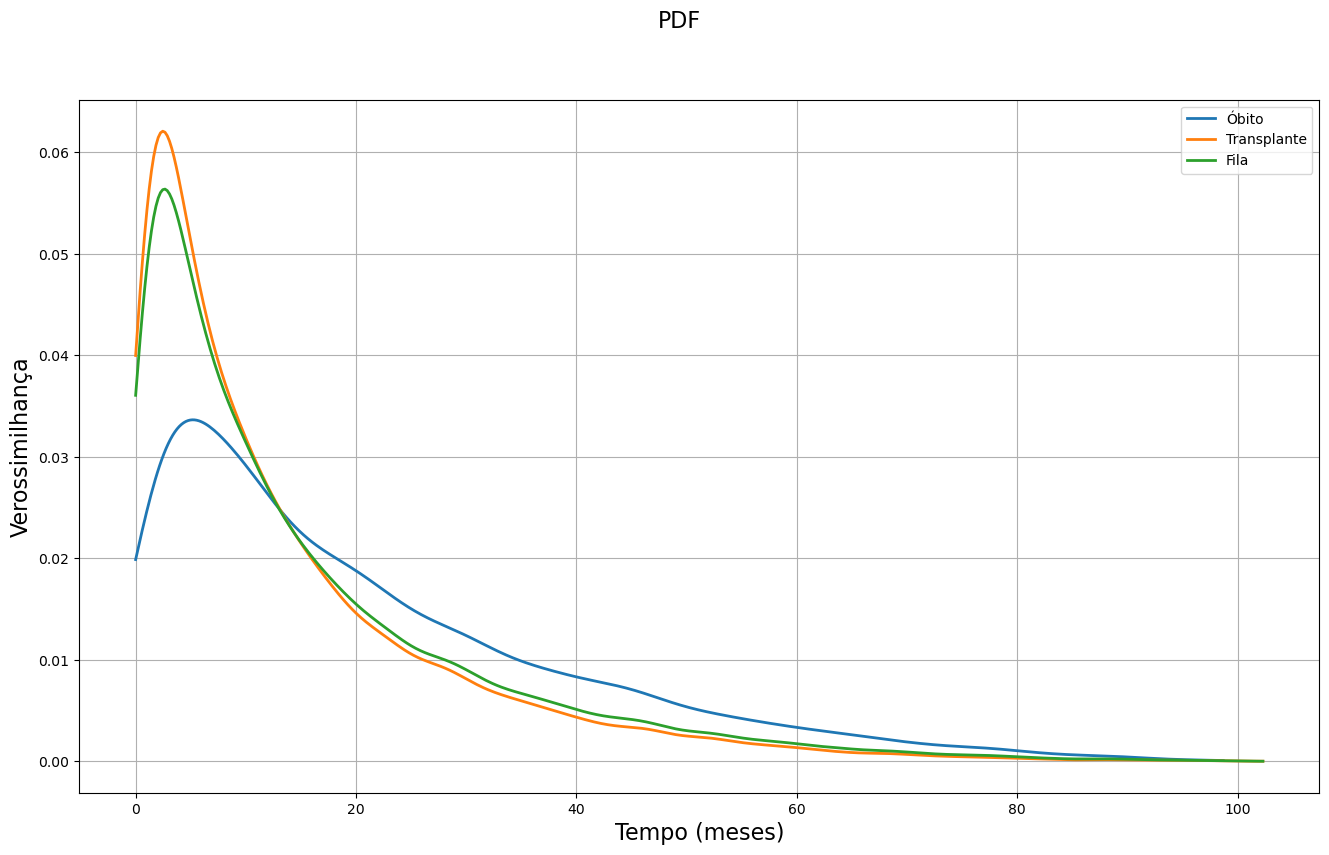

<Figure size 640x480 with 0 Axes>

In [7]:
fig = plt.figure(figsize=[scale * width, scale * height])
ax = fig.add_subplot(1, 1, 1)
fig.suptitle("PDF", fontsize=16)

print("obito: ")
seg_delta_t_negativo = formated_df.delta_t.loc[
    (formated_df.delta_t < 0) & (formated_df.obito_bin == 1)
]
seg_delta_t_positivo = formated_df.delta_t.loc[
    (formated_df.delta_t >= 0) & (formated_df.obito_bin == 1)
].values

seg_delta_t_positivo = seg_delta_t_positivo / 30

gs_kernel = stats.gaussian_kde(seg_delta_t_positivo.astype(np.float64))

# defining attributes limits

smp_max = max(seg_delta_t_positivo)

smp_min = min(seg_delta_t_positivo)

# creating values interval for time optimization

smp_eval = np.linspace(smp_min, smp_max, num=500)

# calculating the likelyhood with kde kernel

smp_likelyhood = gs_kernel(smp_eval)

ax.plot(smp_eval, smp_likelyhood, linewidth=2, label="Óbito")

print("amostras negativas: ", len(seg_delta_t_negativo))
print("amostras positivas: ", len(seg_delta_t_positivo))

# Plotando a curva do transplante
print("transplante: ")
seg_delta_t_negativo = formated_df.delta_t.loc[
    (formated_df.delta_t < 0) & (formated_df.transplante_bin == 1)
]
seg_delta_t_positivo = formated_df.delta_t.loc[
    (formated_df.delta_t >= 0) & (formated_df.transplante_bin == 1)
].values

seg_delta_t_positivo = seg_delta_t_positivo / 30

gs_kernel = stats.gaussian_kde(seg_delta_t_positivo.astype(np.float64))

# defining attributes limits

smp_max = max(seg_delta_t_positivo)

smp_min = min(seg_delta_t_positivo)

# creating values interval for time optimization

smp_eval = np.linspace(smp_min, smp_max, num=500)

# calculating the likelyhood with kde kernel

smp_likelyhood = gs_kernel(smp_eval)

ax.plot(smp_eval, smp_likelyhood, linewidth=2, label="Transplante")

# Plotando curva de fila
print("fila: ")
seg_delta_t_negativo = formated_df.delta_t.loc[(formated_df.delta_t < 0)]
seg_delta_t_positivo = formated_df.delta_t.loc[(formated_df.delta_t >= 0)].values


seg_delta_t_positivo = seg_delta_t_positivo / 30


gs_kernel = stats.gaussian_kde(seg_delta_t_positivo.astype(np.float64))

# defining attributes limits

smp_max = max(seg_delta_t_positivo)

smp_min = min(seg_delta_t_positivo)

# creating values interval for time optimization

smp_eval = np.linspace(smp_min, smp_max, num=500)

# calculating the likelyhood with kde kernel

smp_likelyhood = gs_kernel(smp_eval)

ax.plot(smp_eval, smp_likelyhood, linewidth=2, label="Fila")

print("amostras negativas: ", len(seg_delta_t_negativo))
print("amostras positivas: ", len(seg_delta_t_positivo))

print("amostras negativas: ", len(seg_delta_t_negativo))
print("amostras positivas: ", len(seg_delta_t_positivo))

ax.set_ylabel("Verossimilhança", fontsize=16)
ax.set_xlabel("Tempo (meses)", fontsize=16)

ax.grid()
ax.legend()

plt.show()

plt.savefig("figures/pdf.png")